<a href="https://colab.research.google.com/github/samartha007/Psoriasis-detection-using-transfer-learning/blob/main/Mobile_Net_parameter_tuweking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
#### Modeling
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import cross_val_score,cross_val_predict, StratifiedKFold
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

In [3]:

# Path to the directories containing the class data
class_1_directory = '/content/gdrive/MyDrive/all patch data/disease_with_online_data'
class_2_directory = '/content/gdrive/MyDrive/all patch data/normal'

# Get a list of image filenames for each class
class_1_filenames = os.listdir(class_1_directory)
class_2_filenames = os.listdir(class_2_directory)

# Create empty lists to store the data and labels
data = []
labels = []

# Loop over each image in class 1
for image_filename in class_1_filenames:
    # Read the image
    image_path = os.path.join(class_1_directory, image_filename)
    image = Image.open(image_path)

    # Preprocess the image for VGG16
    image = image.resize((256, 256))
    # image = image.convert('RGB')
    image = np.array(image)
    # image = preprocess_input(image)

    # Add the preprocessed image and corresponding label to the lists
    data.append(image)
    labels.append(0)  # Class 1 is labeled as 0

# Loop over each image in class 2
for image_filename in class_2_filenames:
    # Read the image
    image_path = os.path.join(class_2_directory, image_filename)
    image = Image.open(image_path)

    # Preprocess the image for VGG16
    image = image.resize((256, 256))
    # image = image.convert('RGB')
    image = np.array(image)
    # image = preprocess_input(image)

    # Add the preprocessed image and corresponding label to the lists
    data.append(image)
    labels.append(1)  # Class 2 is labeled as 1

# Convert the lists to NumPy arrays
data = np.array(data)
labels = np.array(labels)
# # Normalize the image data
data = data / 255.0
# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [4]:
## calculating Specificity and Sensitivity
# Creating a function to report confusion metrics
def f1_scores (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]

    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))

    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy

    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))

    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    return conf_f1,conf_sensitivity,conf_specificity


<ipython-input-6-d158d0cc019c>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=50, verbose=0)


3/3 [==============================] - 1s 55ms/step


3/3 [==============================] - 1s 56ms/step


3/3 [==============================] - 1s 41ms/step


3/3 [==============================] - 1s 54ms/step


3/3 [==============================] - 1s 40ms/step


3/3 [==============================] - 1s 57ms/step


3/3 [==============================] - 1s 40ms/step


3/3 [==============================] - 1s 55ms/step


3/3 [==============================] - 1s 56ms/step


3/3 [==============================] - 1s 55ms/step
Cross-validation Results:  [0.71621622 0.91891892 0.87837838 0.97260274 0.82191781]
Mean Accuracy:  0.8616068122917439
Standard Deviation:  0.08786319066993772
Cross-validation Results:  [0.95873968 0.99549887 0.96549137 0.98682171 0.96744186]
Mean ROC:  0.9747986996749187
Standard Deviation:  0.013940525706814304


3/3 [==============================] - 1s 40ms/step


3/3 [==============================] - 1s 40ms/step


3/3 [==============================] - 1s 54ms/step


3/3 [==============================] - 1s 54ms/step


3/3 [==============================] - 1s 54ms/step
Specificity:  0.7023255813953488
Sensitivity:  0.9869281045751634


3/3 [==============================] - 1s 55ms/step


3/3 [==============================] - 1s 55ms/step


3/3 [==============================] - 1s 54ms/step


3/3 [==============================] - 1s 54ms/step


3/3 [==============================] - 1s 59ms/step


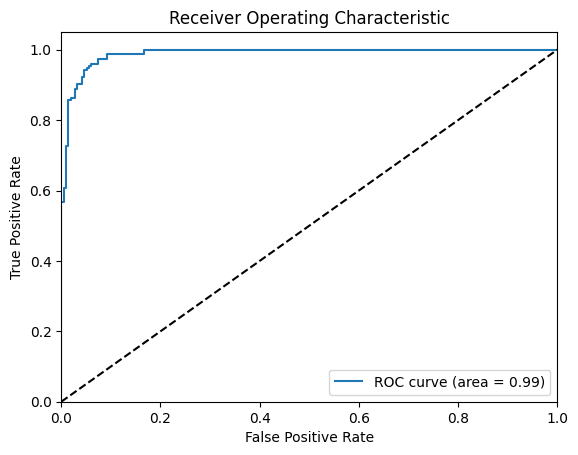

AUC:  0.9884176926584588


In [6]:
# Define a function to create the Keras model
def create_model():
    # Load the pre-trained MobileNet model
    base_model = MobileNet(
    input_shape=(256,256,3),
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=False
)

    # Set up the model architecture
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    base_model.tranable=False
    # Compile the model
    model.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create a scikit-learn compatible KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=50, verbose=0)

# Prepare your data (X and y) for cross-validation

# Define the number of folds for cross-validation
num_folds = 5

# Define the cross-validation strategy (e.g., StratifiedKFold)
cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
results = cross_val_score(model, data, labels, cv=cv, scoring='accuracy')
results1 = cross_val_score(model, data, labels, cv=cv, scoring='roc_auc')
# Print the cross-validation results
print("Cross-validation Results: ", results)
print("Mean Accuracy: ", np.mean(results))
print("Standard Deviation: ", np.std(results))

# Print the cross-validation results
print("Cross-validation Results: ", results1)
print("Mean ROC: ", np.mean(results1))
print("Standard Deviation: ", np.std(results1))
# Perform cross-validation
y_pred = cross_val_predict(model, data, labels, cv=cv)

# Compute the confusion matrix
cm = confusion_matrix(labels, y_pred)

# Extract true negatives, false positives, false negatives, and true positives
tn, fp, fn, tp = cm.ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

# Print the specificity and sensitivity
print("Specificity: ", specificity)
print("Sensitivity: ", sensitivity)
# Perform cross-validation
y_pred_proba = cross_val_predict(model, data, labels, cv=cv, method='predict_proba')[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(labels, y_pred_proba)

# Compute the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print the AUC
print("AUC: ", roc_auc)
